In [1]:
import dtale as dtale
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, MaxAbsScaler, OneHotEncoder

## Global parameters setup

Executing methods that do some data transformation which involves randomness (i.e. sampling or data splitting) yields different result for each run. In order to have predictable results we can leverage the function argument called `random_state` and set it to a constant value (`randomness_id`).

In [2]:
# @formatter:off
%matplotlib inline
# %matplotlib notebook
# @formatter:on
randomness_id = 5100
np.random.seed(randomness_id)

In [3]:
df = pd.read_csv("./data/Video_Games_Sales_as_at_22_Dec_2016.csv")
df.shape

(16719, 16)

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [6]:
print(f"There are {df.isnull().any(axis=1).sum()} rows with missing data.")
print(f"There are {df.isnull().sum().sum()} missing data fields within these rows.")
df.isnull().sum()

There are 9894 rows with missing data.
There are 46716 missing data fields within these rows.


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [7]:
df = df[df["Name"].notna() & df["Year_of_Release"].notna() & df["Publisher"].notna()]
# df["Year_of_Release"] = df["Year_of_Release"].fillna(df["Year_of_Release"].mean()).astype(int)
df.shape

(16416, 16)

In [8]:
df.nunique(dropna=True)

Name               11397
Platform              31
Year_of_Release       39
Genre                 12
Publisher            579
NA_Sales             401
EU_Sales             307
JP_Sales             244
Other_Sales          155
Global_Sales         628
Critic_Score          81
Critic_Count         106
User_Score            96
User_Count           883
Developer           1680
Rating                 8
dtype: int64

In [9]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000,7982.000000,7982.000000,7461.000000
mean,2006.489888,0.264129,0.146034,0.078623,0.047670,0.536708,68.997119,26.440992,163.008846
std,5.881148,0.819028,0.507134,0.311348,0.188156,1.559885,13.918755,19.009305,563.932422
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,22.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


<AxesSubplot:>

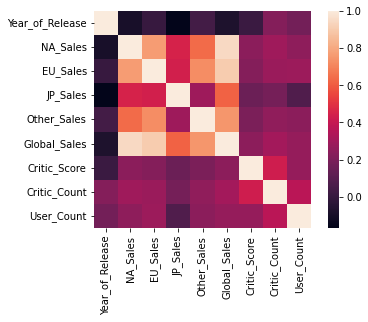

In [10]:
sns.heatmap(df.corr(), square=True)  #Plot the correlation as heat map

In [11]:
pure_df = df[df.notna().all(axis=1)]
print(pure_df.shape)
pure_df.info()

(6825, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   object 
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(9), object(7)
memory usage: 906.4+ KB

In [18]:
pure_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


                                             |          | [  0%]   00:00 -> (? left)


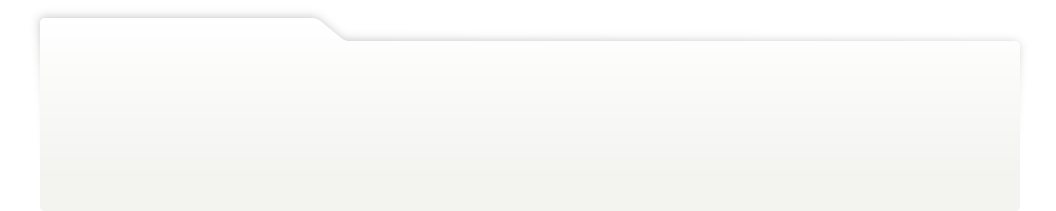
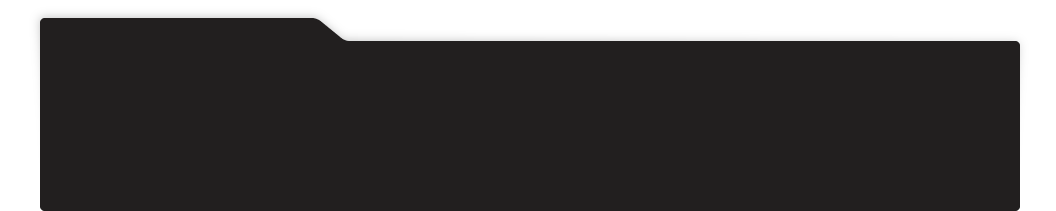
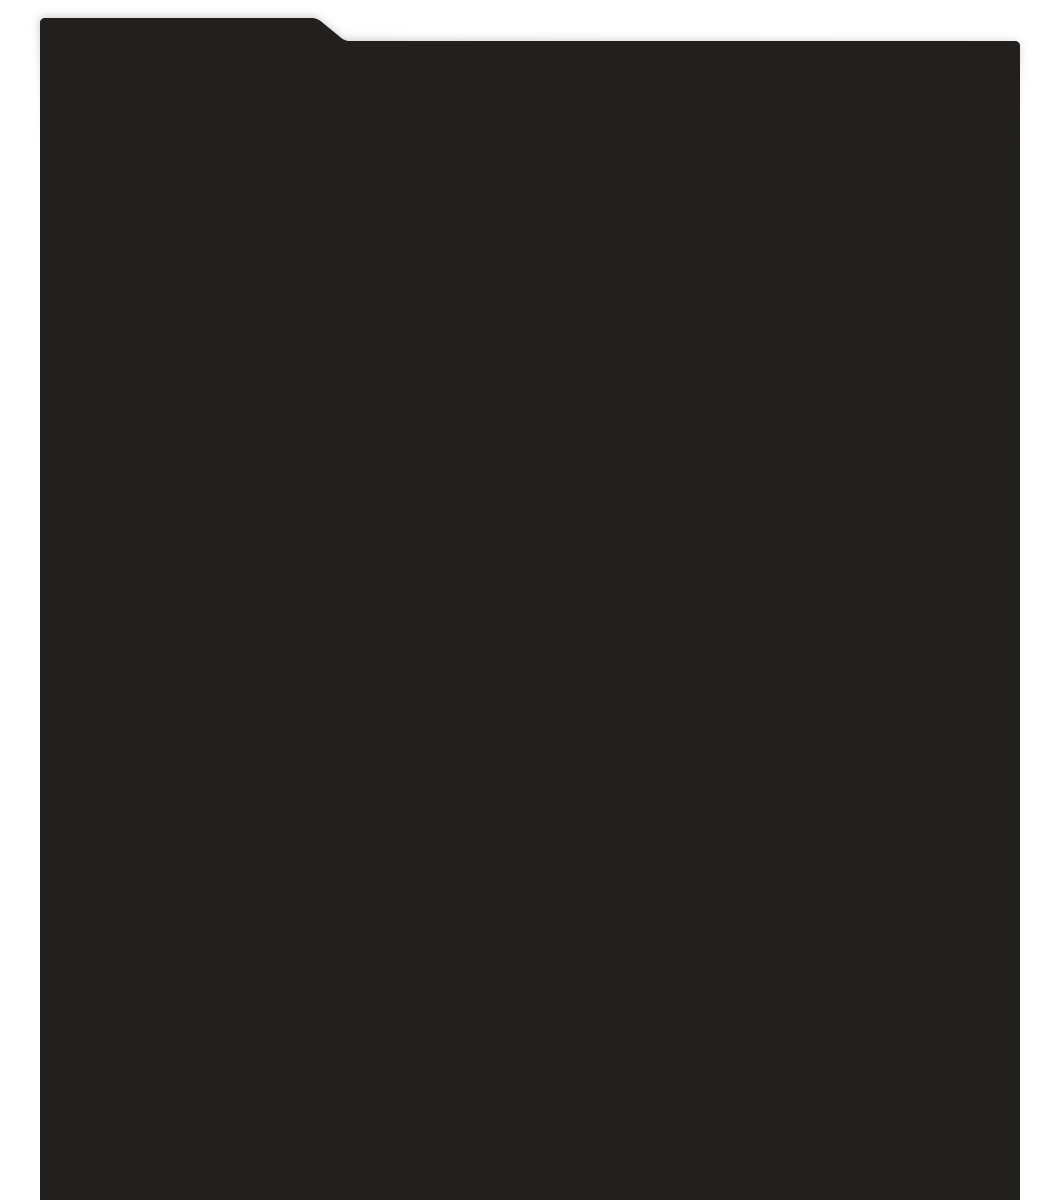
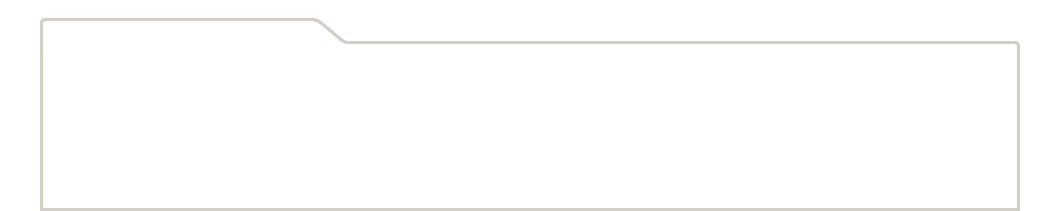
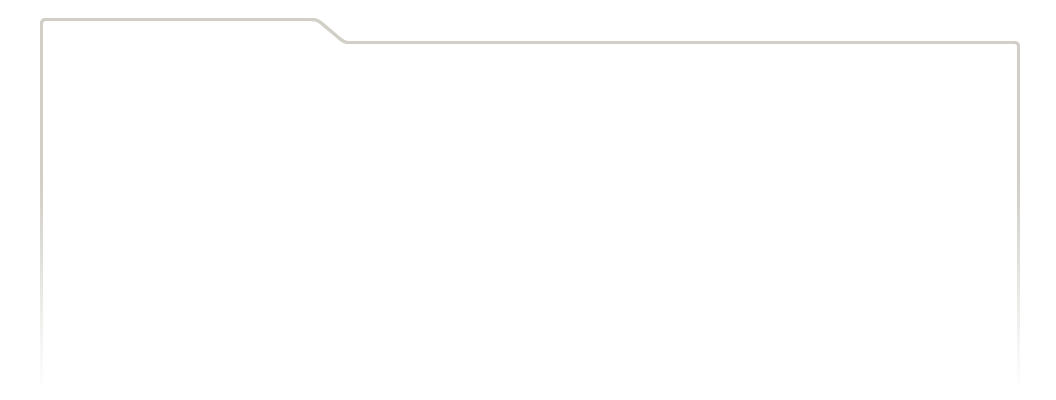
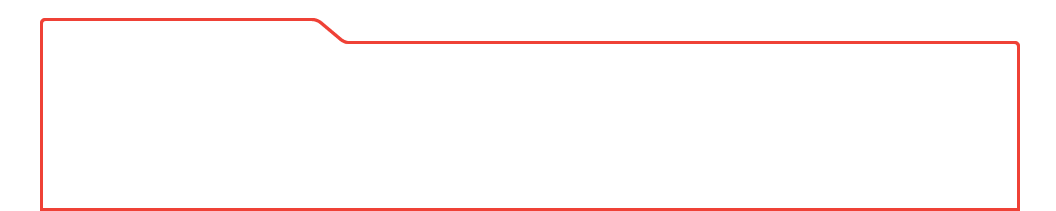
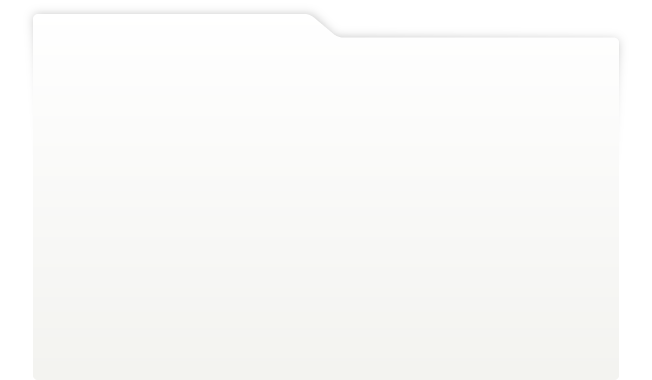
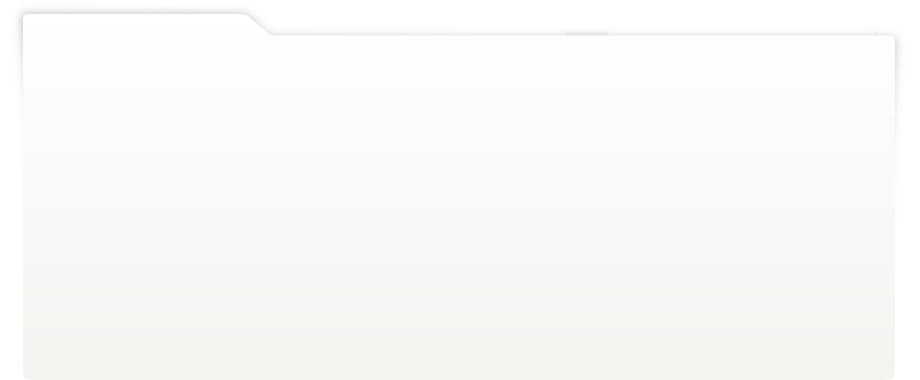
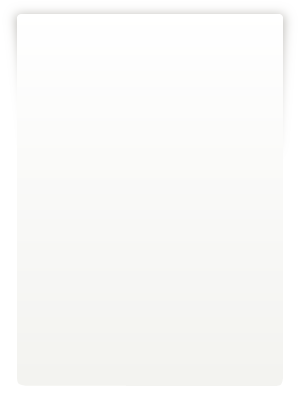
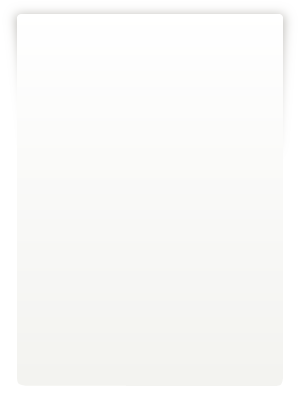
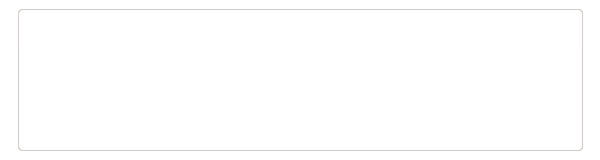
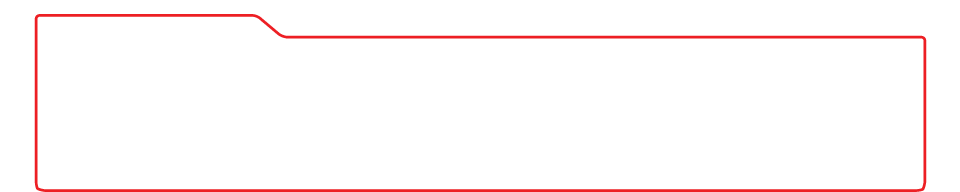
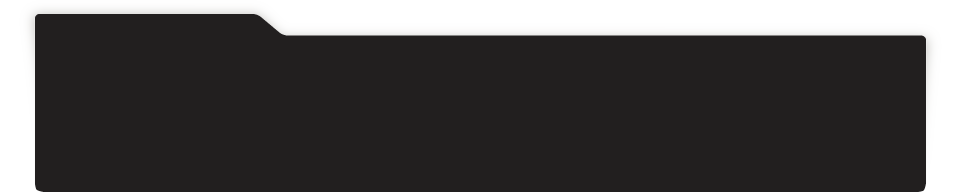
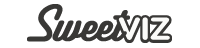
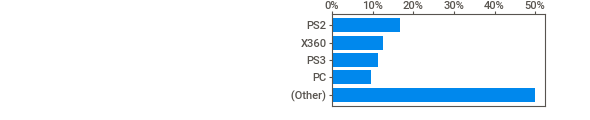
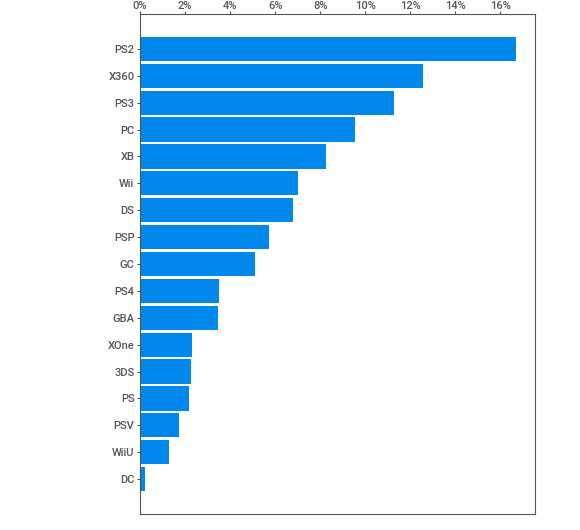
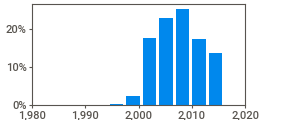
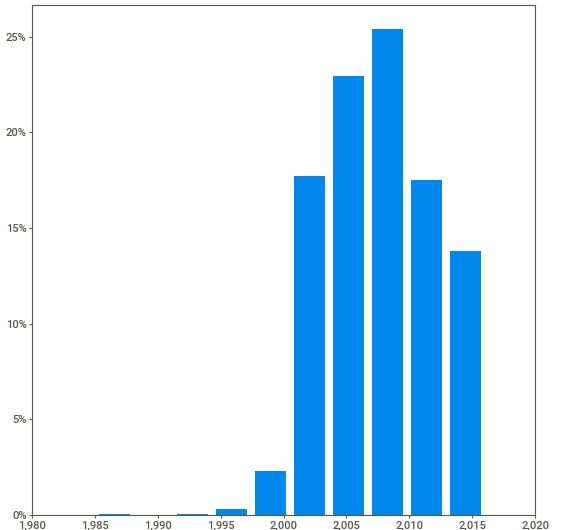
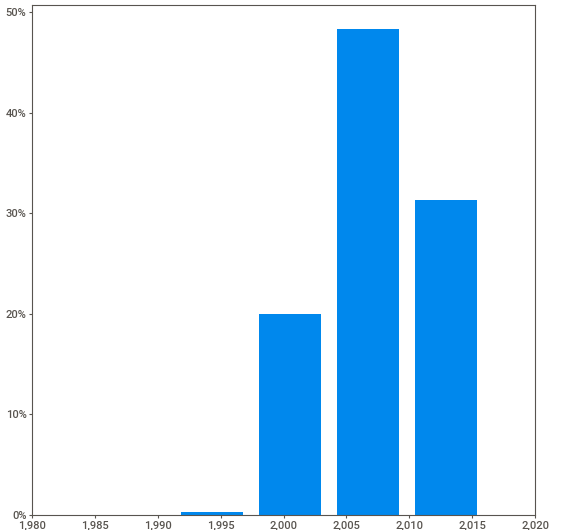
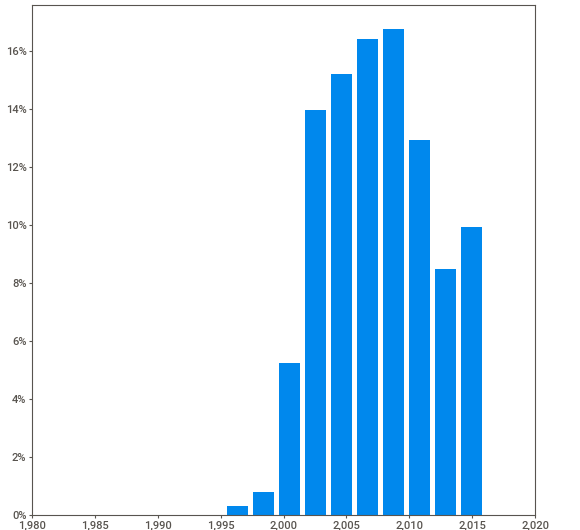
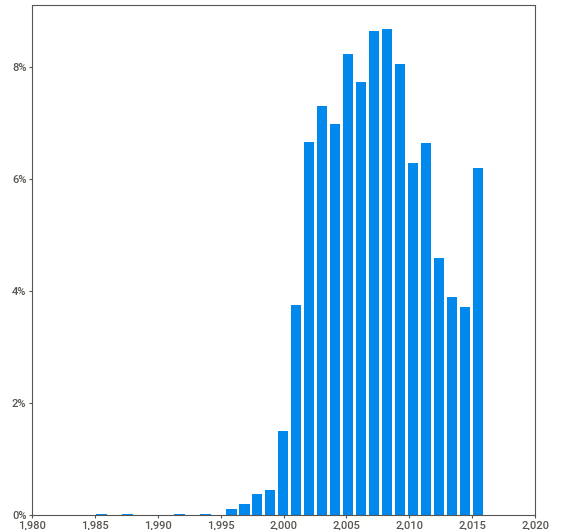
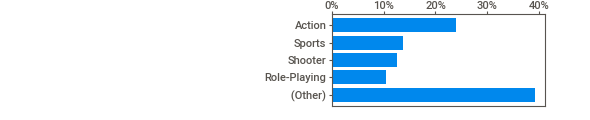
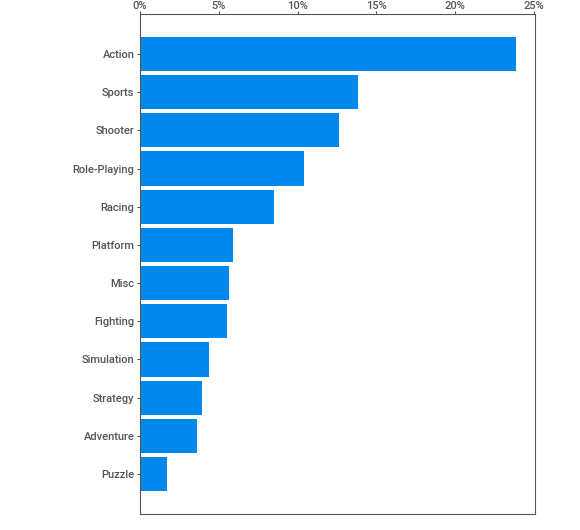
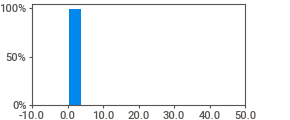
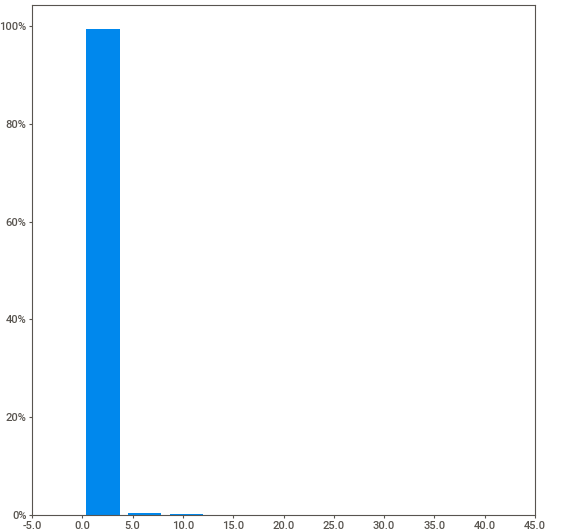
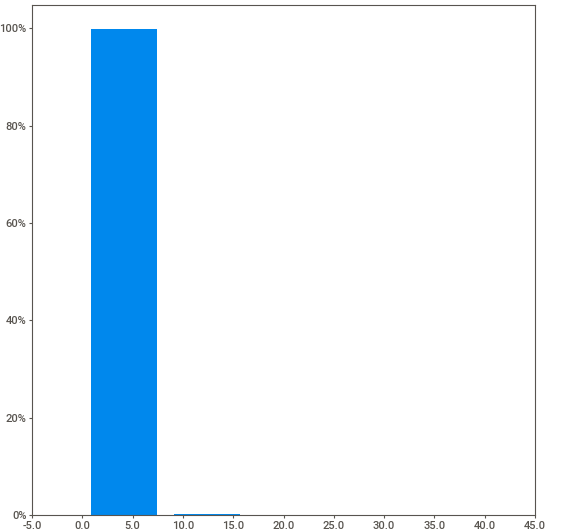
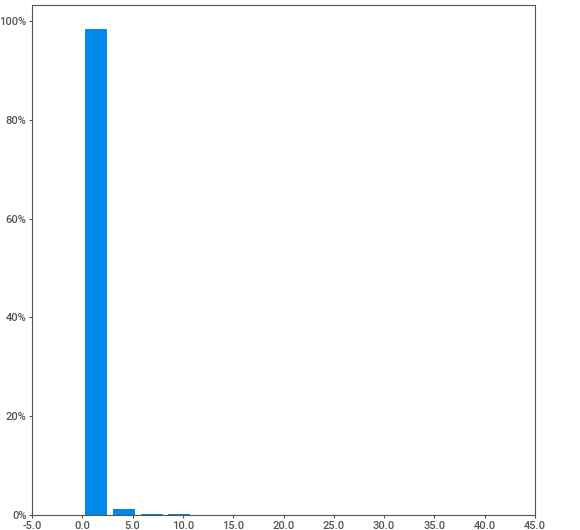
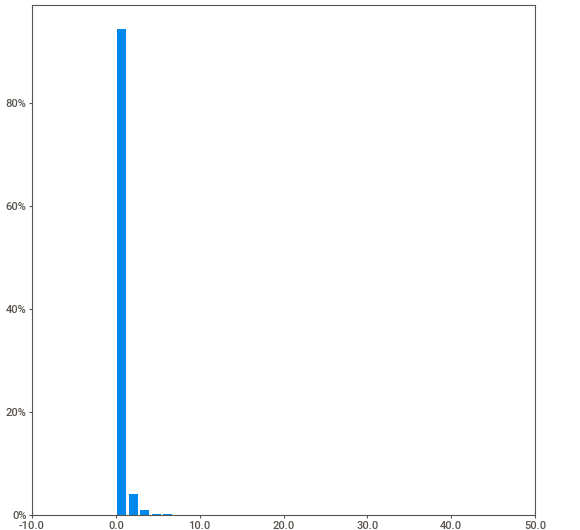
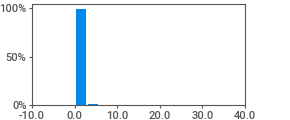
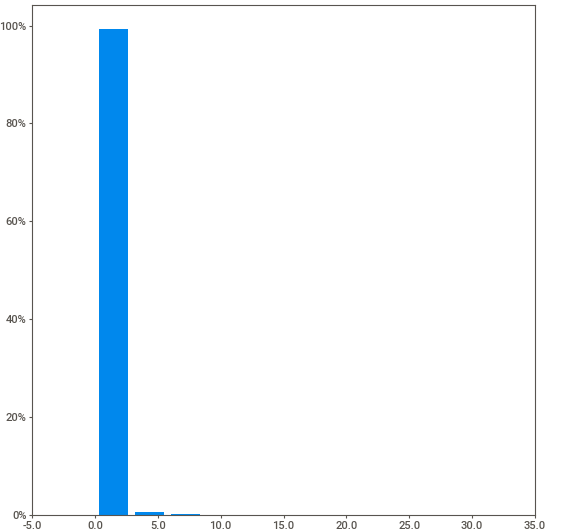
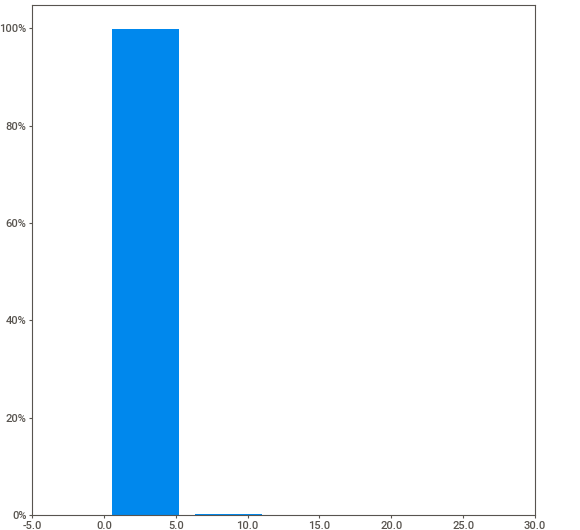
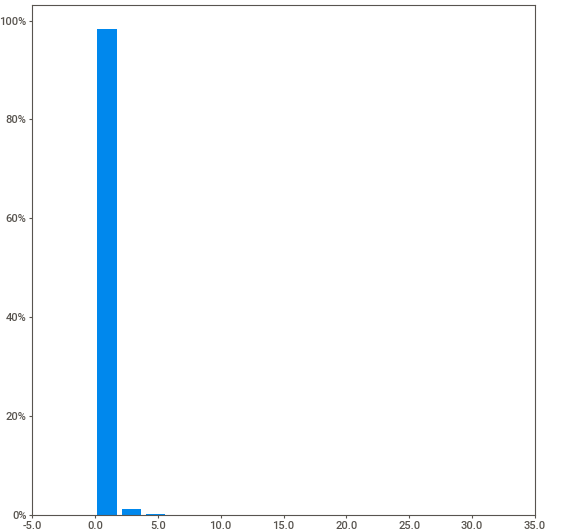
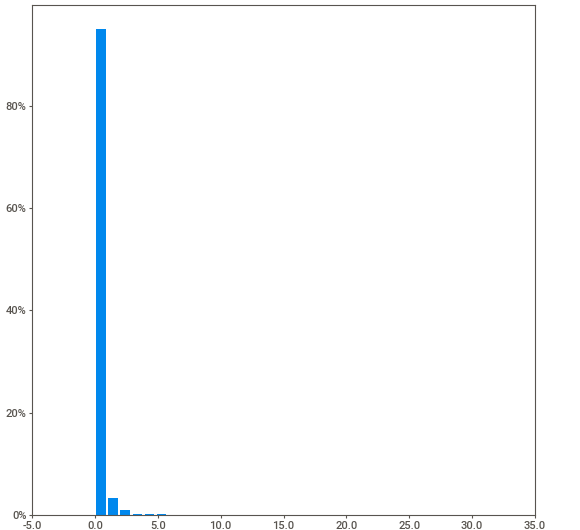
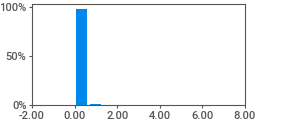
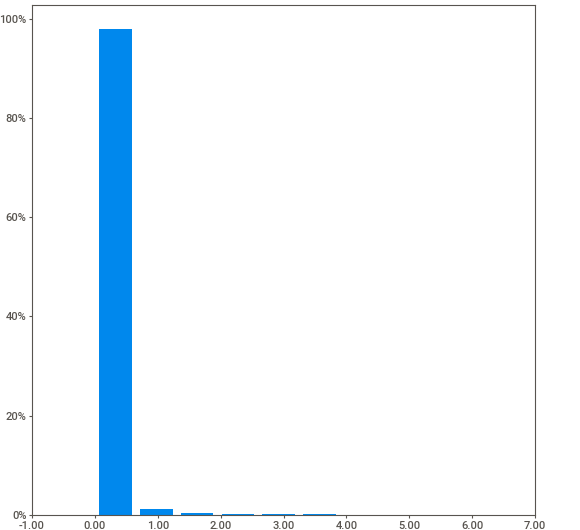
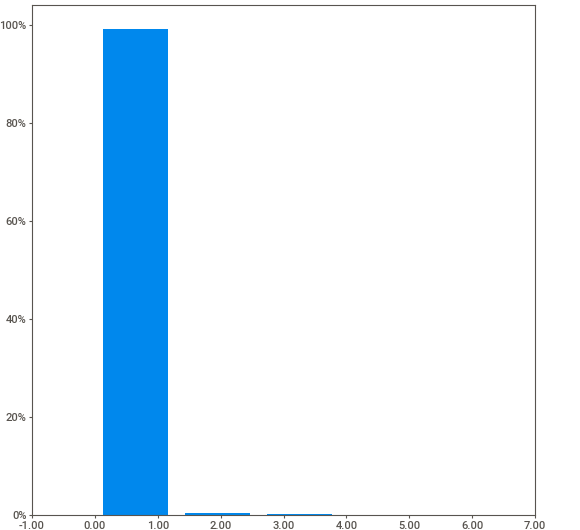
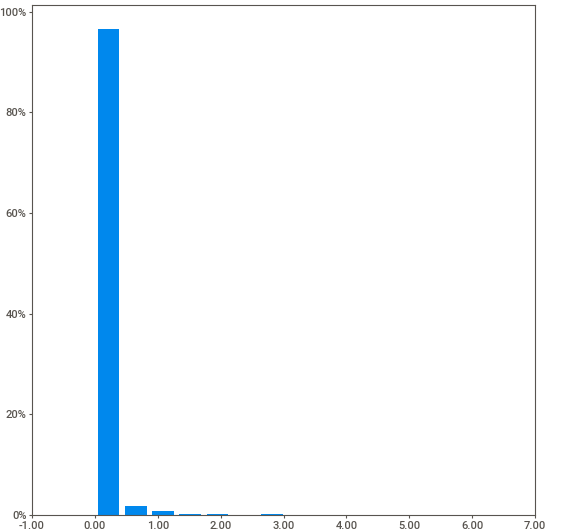
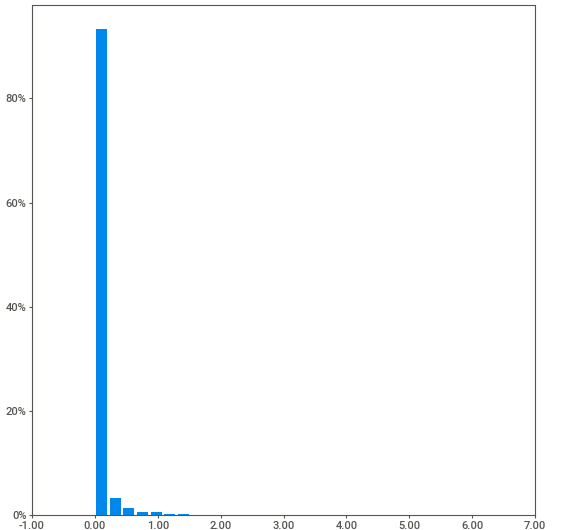
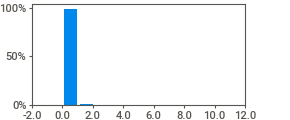
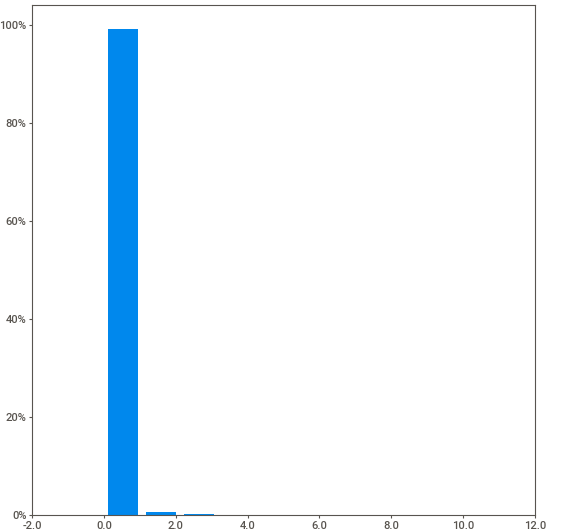
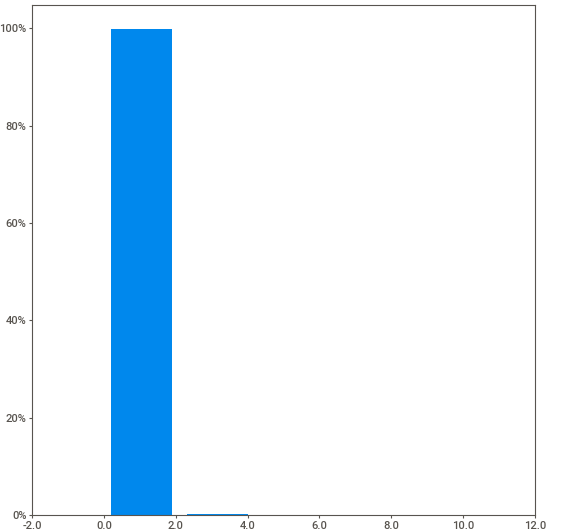
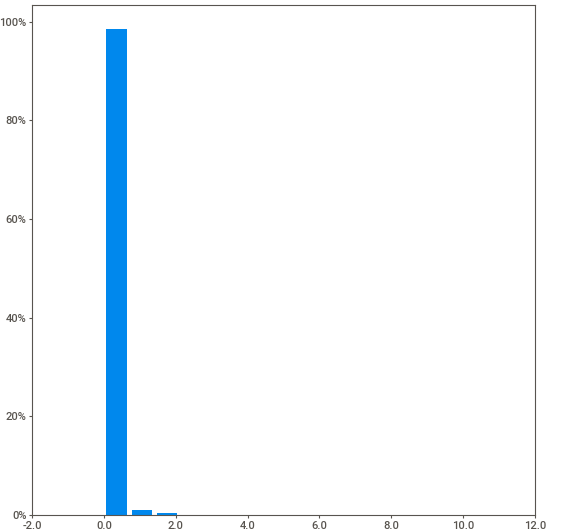
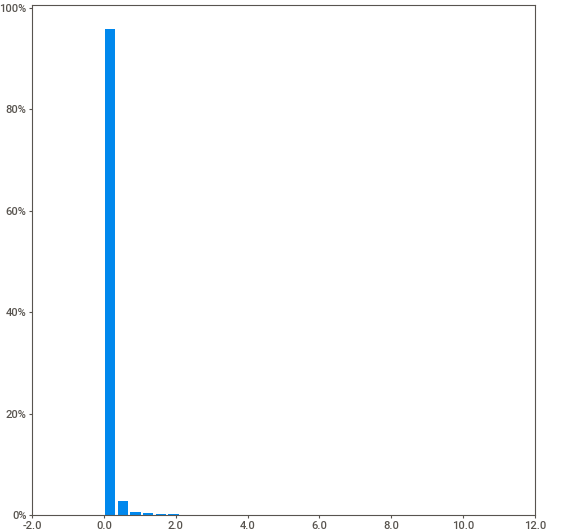
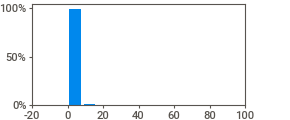
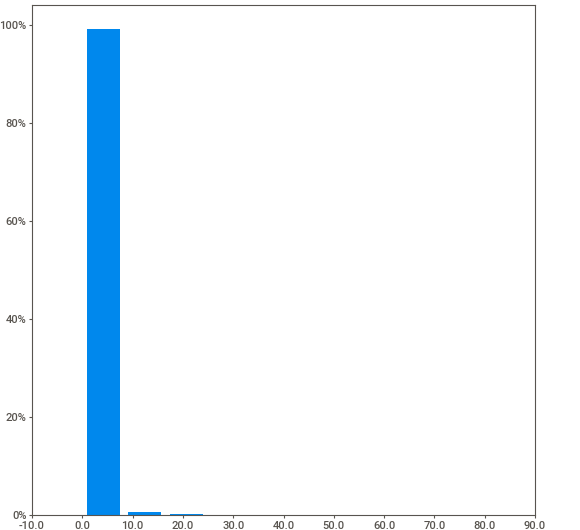
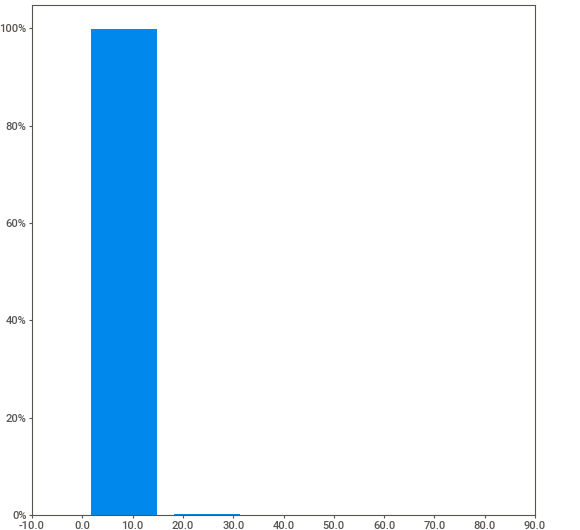
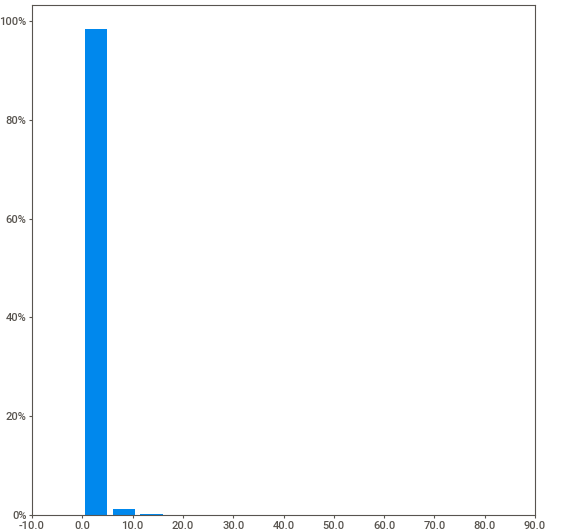
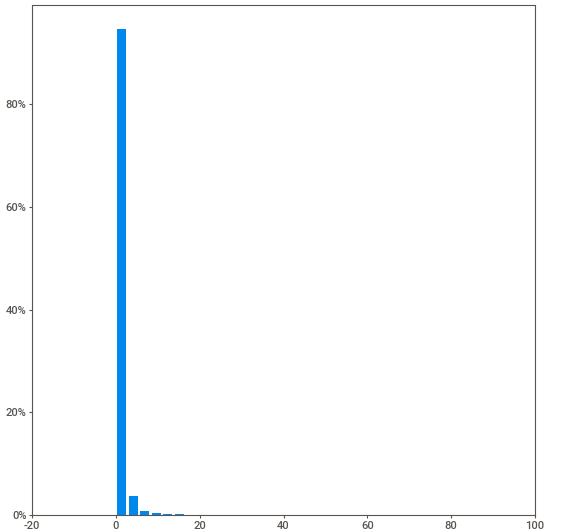
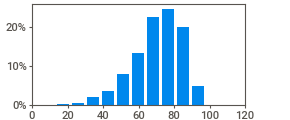
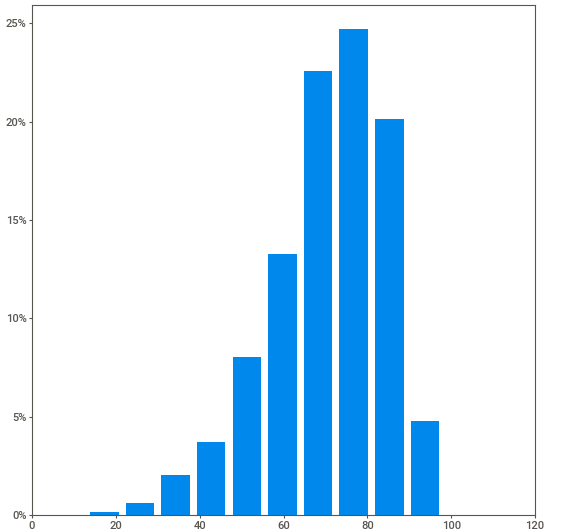
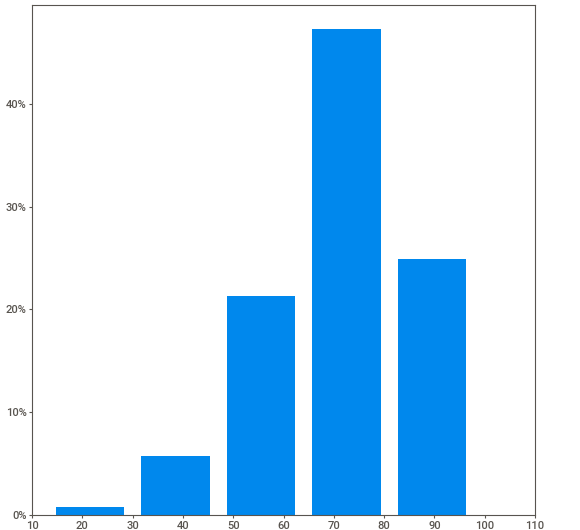
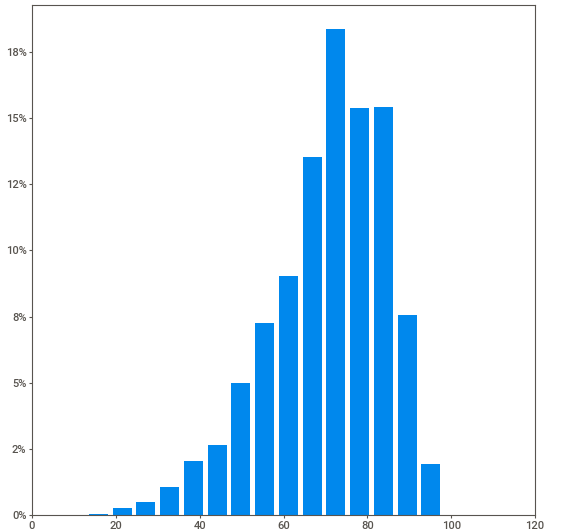
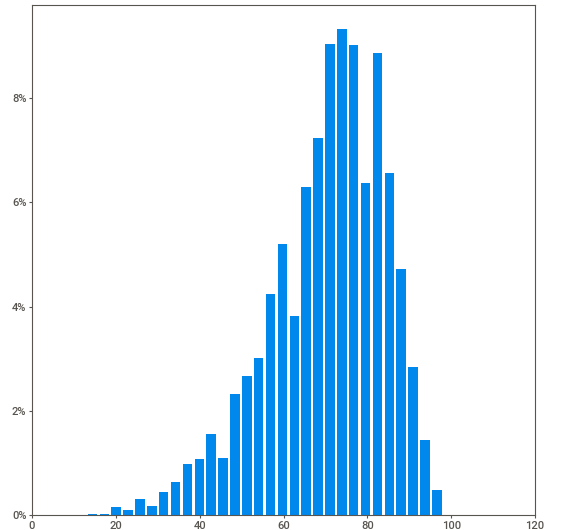
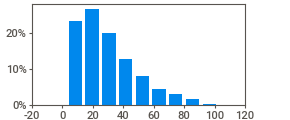
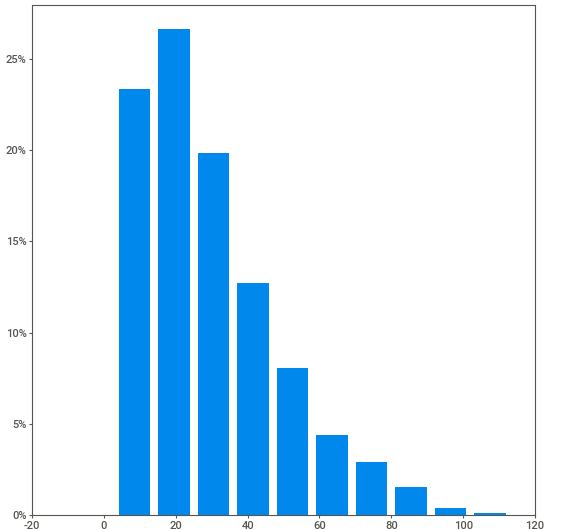
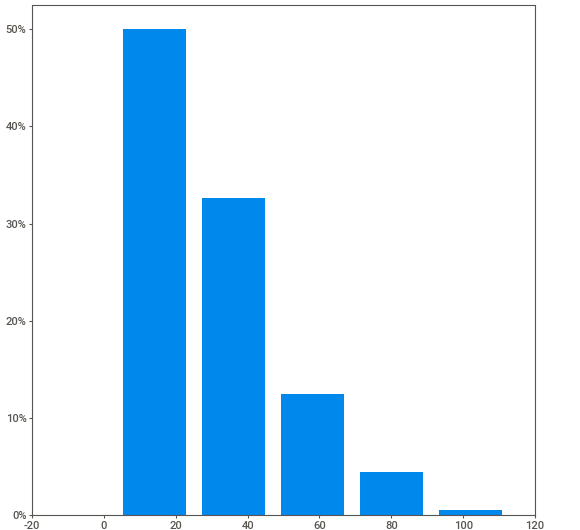
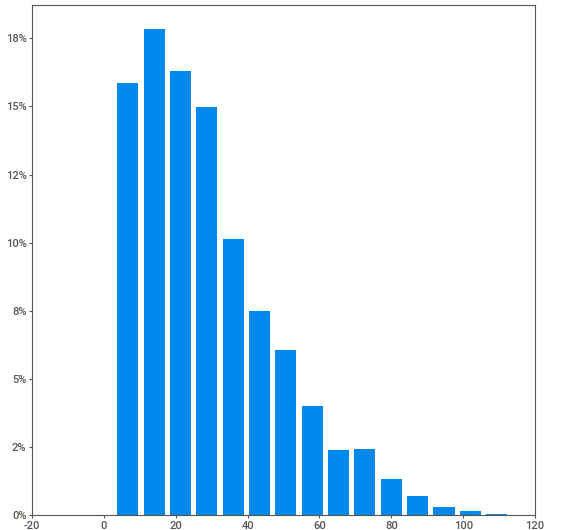
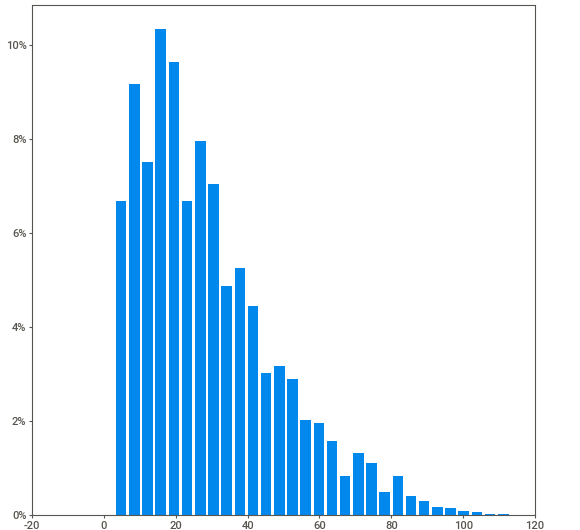
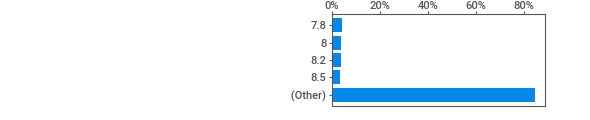
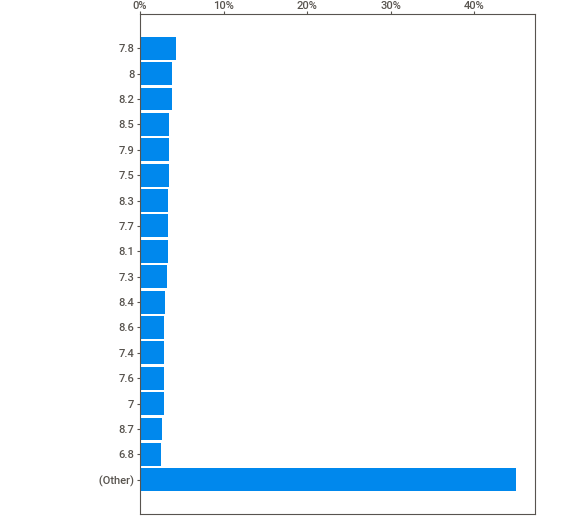
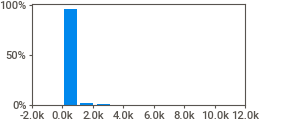
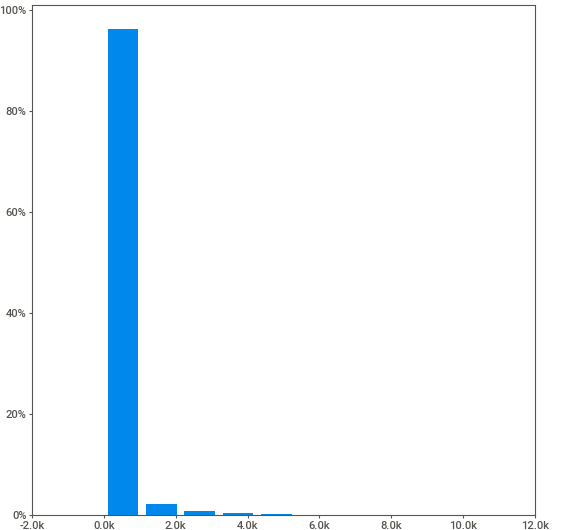
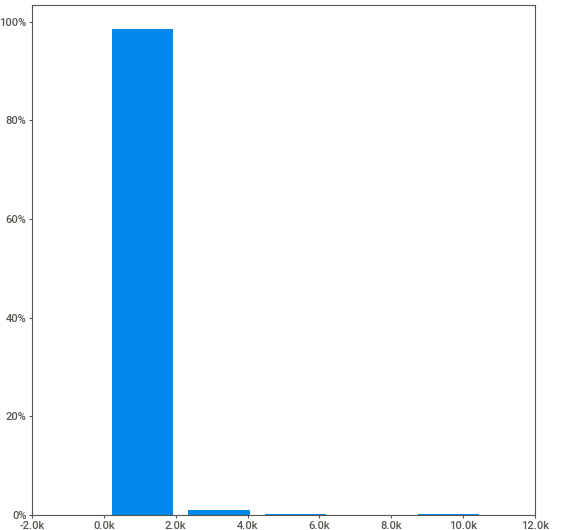
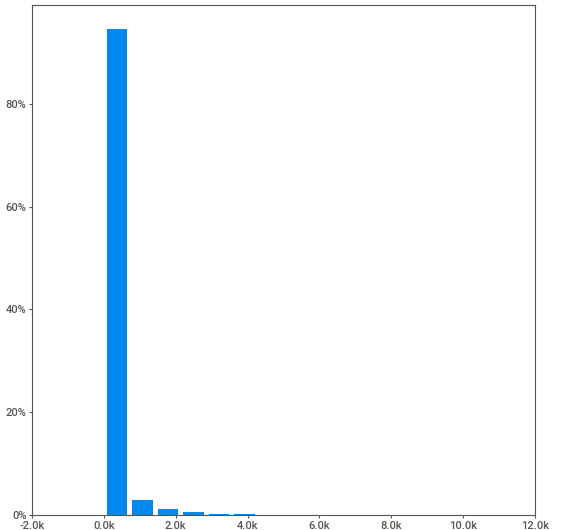
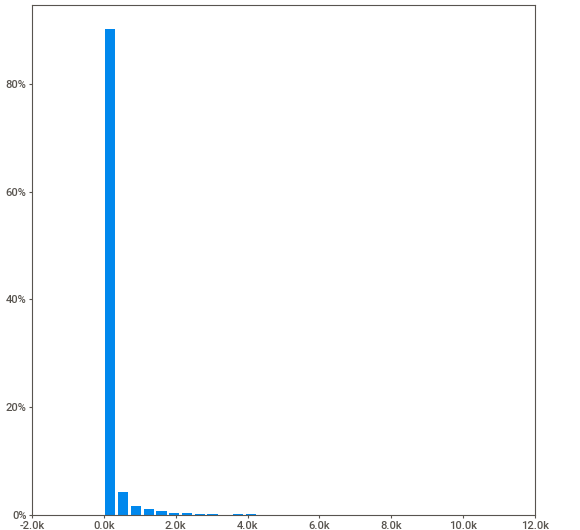
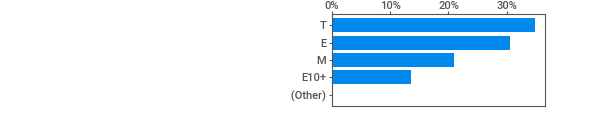
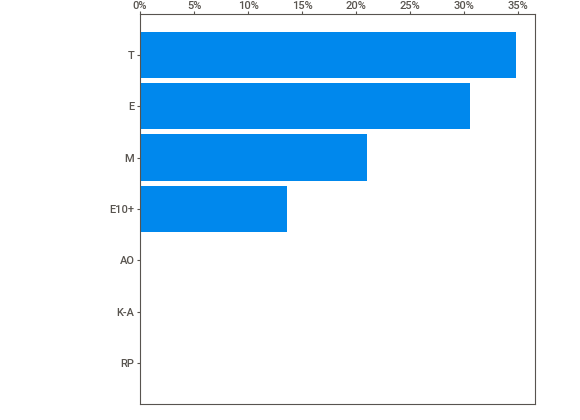
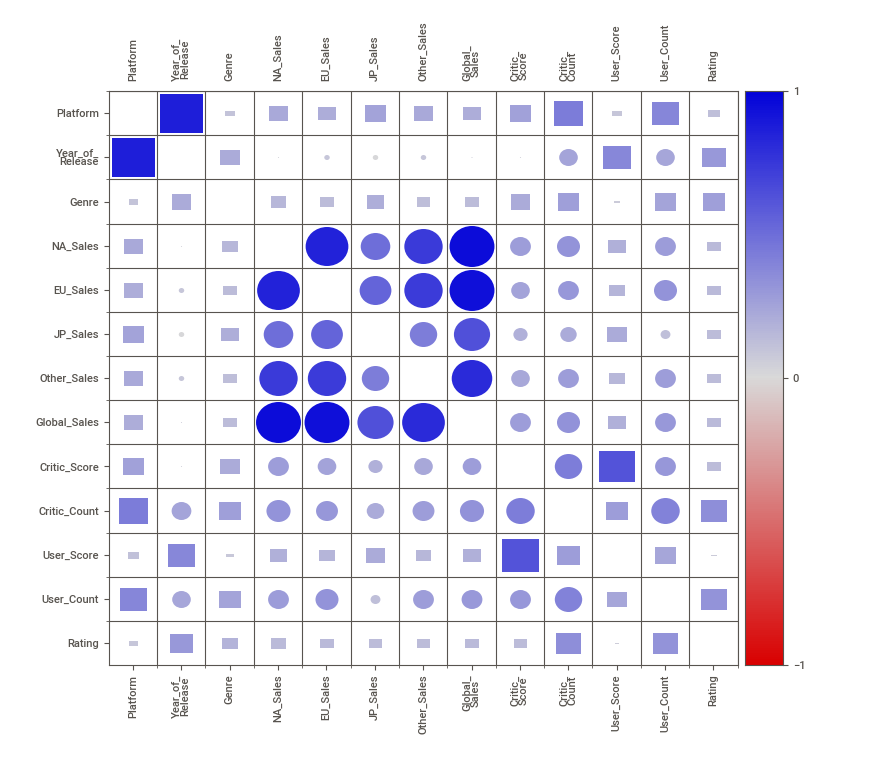
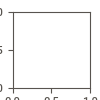

In [12]:
report = sv.analyze(pure_df, pairwise_analysis='on')
report.show_notebook()


In [13]:
dtale.show(pure_df)

In [14]:
class PipelineFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(PipelineFriendlyLabelBinarizer, self).fit_transform(X)


preprocessor = Pipeline(
    [
        ("encoder", OneHotEncoder()),
        ("scaler", MaxAbsScaler()),
        ("pca", TruncatedSVD(n_components=2, random_state=randomness_id)),
    ]
)

clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=5,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

pipe.fit(pure_df)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder', OneHotEncoder()),
                                 ('scaler', MaxAbsScaler()),
                                 ('pca', TruncatedSVD(random_state=5100))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [15]:
preprocessed_data = pipe["preprocessor"].transform(pure_df)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5040084111984241

In [16]:
silhouette_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(pure_df)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(pure_df),
        pipe["clusterer"]["kmeans"].labels_,
    )
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)

silhouette_scores

[0.5040084111984241,
 0.487735753698036,
 0.4512678107566785,
 0.34186398600669526,
 0.2947145109824131,
 0.25551364151306194,
 0.2721053258605893,
 0.2519431993709651,
 0.23279004951258195]